# 1.5 Finite Difference Method - 1U1C Model - Different Controls Applications

Prepared by (C) Vasken Dermardiros

Okay. Now we're getting somewhere. We will now simulate a room using a very simple model: it has one conductance and one capacitance (1U1C). We introduce it here, but we will do a few more neat things with it later on.

We will start by first letting it free float. Next, we will add a heating and cooling source in order to maintain the room air temperature fixed at 21°C using proportional control. Next we will simulate on/off controls with a deadband. Finally, let's put in a night-time setback and create a deadband (a temperature range where no heating nor cooling will be applied to the room).

------------
## FDM Implementation
### Load Dependencies

In [1]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
# Plot in notebook; comment out the line below for windowed plots
%matplotlib inline
# mpl.rc('figure', figsize=(10, 10))

### Variable Names
Uin: Conductance matrix input by user, upper triangle only, (nN x nN) (W/K)  
U: Conductance matrix (symmetrical) with added capacitance for diagonal term, (nN x nN) (W/K)  
C: Capacitance vector, (nN x 1) (J/K)  
F: Conductance matrix of nodes connected to a known temperature source, (nN x nM) (W/K)  
T: Temperature vector per timestep, (nT x nN) (degC)  
TK: Temperature vector of known temperatures per timestep, (nT x nM) (degC)  
Qin: Heat flow, only external sources, (nN x 1) (W)  
Q: Heat flow vector + external sources + capacitance from previous timestep (implicit only), (nN x 1) (W)  
  
nN: Number of nodes  
nM: Number of nodes with known temperatures  
nT: Number of timesteps  

Node Number: Object  
0: effective room node, connected to the capacitor and T_ambient (in the TKs)  

Node Number with known temperatures: Object  
0: ambient air

In [2]:
# Number of nodes
nN = 1
nM = 1

# Properties
U_simple = 2.  # K/W
C_simple = 3e5 # J/K

### Simulation Parameters

In [3]:
st = 4          # steps per hour
H = 24          # hr; number of hours simulated
nt = int(st*H)  # number of timesteps-1
dt = 3600/st    # s (3600 sec = 1 hour)
days = 10       # number of days simulated

### Nodal Connections
This is what differenciates the models from one another: how are the nodes connected to each other? What is the conductance in between? How much thermal capacitance do the nodes have?

In [4]:
# Declare variables
Uin = np.zeros((nN,nN))     # K/W
F = np.zeros((nN,nM))       # K/W
C = np.zeros((nN,1))        # J/K

# How are the nodes connected?
# Uin[0,0] = 0

# Connected to temperature sources
F[0,0] = (1/U_simple)**-1

# Nodes with capacitance: rho*cp*volume
C[0] = C_simple

### Temperatures and Known Temperatures

In [5]:
# Declare variables
T = np.zeros((nt*days, nN))    # degC
TK = np.zeros((nt*days, nM))   # degC

# Known temperature sources
T_out_m = -15.              # degC, Exterior temperature
dT_out = 10.                # degC, Temperature differential
T_out_theta = -5*np.pi/4    # Shift
w = 2*np.pi/86400           # Period
T_out = days*[T_out_m + dT_out/2*np.cos(w*t*dt + T_out_theta) for t in range(nt)]
TK[:,0] = T_out             # degC; Exterior temperature

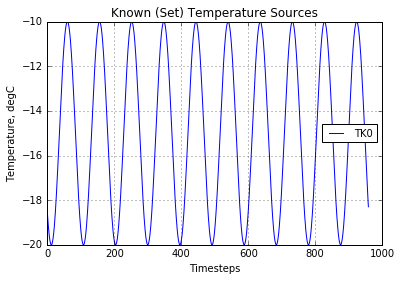

In [6]:
# Plot known temperature sources
fig = plt.figure()
plt.plot(TK)
labels = ['TK' + str(n) for n in range(nM)]
plt.legend(labels,loc='best', fontsize='medium')
plt.xlabel('Timesteps')
plt.ylabel('Temperature, degC')
plt.title('Known (Set) Temperature Sources')
plt.grid()
plt.show()

### Initial Conditions

In [7]:
T[0,] = 10.      # all temperatures set to 10 degC

------------
## Run Simulation, Free Float (Implicit Scheme)

### U-matrix completion

In [8]:
# Here, we complete the connections due to symmetry 
# Node 0 is connected to node 1; also, node 1 is connected to node 0.
U = -Uin - Uin.T  # U is symmetrical, non-diagonals are -ve
s = -np.sum(U,1)
for i in range(0,nN):
    U[i,i] = s[i] + np.sum(F[i,]) + C[i]/dt
del s

### Main Loop

In [9]:
# Loop for number of days, and for all timesteps in a day
for d in range(0,days):
    for t in range(0,nt):
        
        # Heat flow into the node, external sources
        Qin = np.zeros((nN,1))
        # Qin[1] = q_in[t]

        # Q-vector: Q = Qin + F*TM(t) + C/dt*T(t)
        Q = Qin + np.reshape(np.dot(F, TK[d*nt+t,]),(nN,1)) + \
        np.multiply(C/dt, np.reshape(T[d*nt+t,:],(nN,1)))

        # Compute temperature
        # This is where the magic happens. For a system where nothing changes 
        # (no controls, no moveable blinds, no PCM; we need only define the 
        # U-matrix once (done above) and use it here)
        if (days*nt) > (d*nt+t+1):
            T[d*nt+t+1,] = np.linalg.solve(U,Q).T

### Plotting

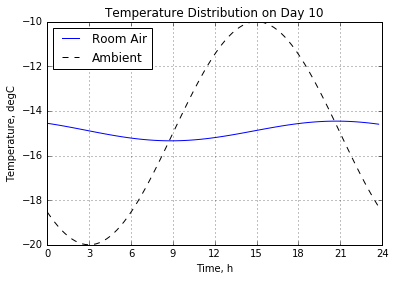

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.hold(True)
plotT = T[(days-1)*nt:(days)*nt:]
plt.plot(np.dot(dt/3600.,range(0,nt)),plotT)
plotTK = TK[(days-1)*nt:(days)*nt:]
plt.plot(np.dot(dt/3600.,range(0,nt)),plotTK,'k--')
plt.xlim([0,24])
ax.set_xticks(np.arange(0,25,3))
plt.legend(['Room Air','Ambient'],loc='best')
plt.xlabel('Time, h')
plt.ylabel('Temperature, degC')
plt.title('Temperature Distribution on Day %s' %(days))
plt.grid()
plt.show()

------------
## Run Simulation, with Heating and Cooling, Proportional Controls (Implicit Scheme)

In [11]:
# Heating and cooling system
q_reqd = np.zeros((nt*days, 1)) # heating/cooling supplied to air node
T_Setpoint = 21.            # degC, Setpoint temperature
Kp = 100.                   # Proportionality constant
capacity = 1000.            # W, heating / cooling maximum capacity

In [12]:
# Loop for number of days, and for all timesteps in a day
for d in range(0,days):
    for t in range(0,nt):
        
        # Heat flow into the node, external sources
        Qin = np.zeros((nN,1))
        # Calculate the heating/cooling power required based on the previous temperature
        q_reqd[d*nt+t] = Kp*(T_Setpoint - T[d*nt+t,]) # +ve = heating
        if (q_reqd[d*nt+t] > capacity):  q_reqd[d*nt+t] = capacity
        if (q_reqd[d*nt+t] < -capacity): q_reqd[d*nt+t] = -capacity
        Qin[0] = q_reqd[d*nt+t]

        # Q-vector: Q = Qin + F*TM(t) + C/dt*T(t)
        Q = Qin + np.reshape(np.dot(F, TK[d*nt+t,]),(nN,1)) + \
        np.multiply(C/dt, np.reshape(T[d*nt+t,:],(nN,1)))

        # Compute temperature
        # This is where the magic happens. For a system where nothing changes 
        # (no controls, no moveable blinds, no PCM; we need only define the 
        # U-matrix once (done above) and use it here)
        if (days*nt) > (d*nt+t+1):
            T[d*nt+t+1,] = np.linalg.solve(U,Q).T

### Plotting

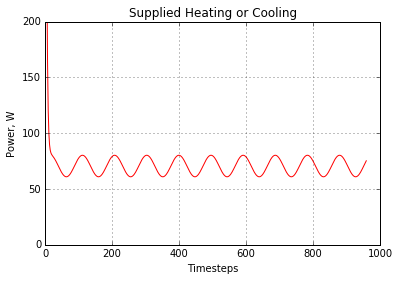

In [13]:
plt.plot(q_reqd,'r')
plt.xlabel('Timesteps')
plt.ylabel('Power, W')
plt.title('Supplied Heating or Cooling')
plt.ylim((0,200))
plt.grid()
plt.show()

We can see that the system is oscillating to try to maintain the setpoint. In smaller systems, typically the heater has one (or a small discrete number of) setting and will toggle on and off continuously. For some components, this actuation can lead to premature failure and should be avoided. In the following section, we will look at how a typical small system behaves.

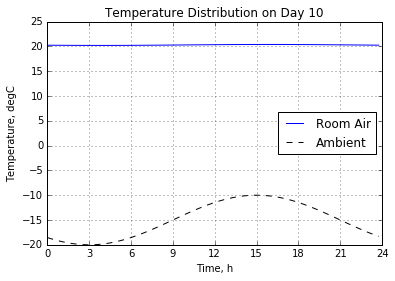

In [14]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.hold(True)
plotT = T[(days-1)*nt:(days)*nt:]
plt.plot(np.dot(dt/3600.,range(0,nt)),plotT)
plotTK = TK[(days-1)*nt:(days)*nt:]
plt.plot(np.dot(dt/3600.,range(0,nt)),plotTK,'k--')
plt.xlim([0,24])
ax.set_xticks(np.arange(0,25,3))
plt.legend(['Room Air','Ambient'],loc='best')
plt.xlabel('Time, h')
plt.ylabel('Temperature, degC')
plt.title('Temperature Distribution on Day %s' %(days))
plt.grid()
plt.show()

As we can see above, with certain control parameters, the room air temperature comes quite close to our desired set point, however, there is a bias of around 1 degrees. To remedy the problem, an integral term should be added to the controller -- to obtain a PI controller.

------------
## Run Simulation, Setpoints with  Deadband, Bang-Bang Controls
In this section, we will be looking at Bang-Bang controls (on/off). When the temperature drops below the setpoint, the heater is turned on, when it passes the deadband, it's turned off. If the room temperature passes the cooling setpoint, the chiller is turned on.

In [15]:
# Heating and cooling system, bang-bang controls
q_reqd = np.zeros((nt*days, 1)) # heating/cooling supplied to air node
T_Setpoint_Heating = 21.*np.ones((nt*days, 1)) # degC, Heating setpoint temperature
T_Setpoint_Cooling = 24.*np.ones((nt*days, 1)) # degC, Heating setpoint temperature
deadband = 1.
capacity = 500.             # W, heating / cooling maximum capacity, pulled out of my... hat.
heater_on = False           # heating system toggle
cooler_on = False           # cooling system toggle

In [16]:
# Loop for number of days, and for all timesteps in a day
for d in range(0,days):
    for t in range(0,nt):
        
        # Heat flow into the node, external sources
        Qin = np.zeros((nN,1))
        # Determine if room temperature is below heating setpoint or above cooling setpoint
        # Based on the previous temperatures. If the current one is needed, this loop should
        # be iterated.
        if (T[d*nt+t,] < T_Setpoint_Heating[d*nt+t]): heater_on = True
        if (T[d*nt+t,] > T_Setpoint_Cooling[d*nt+t]): cooler_on = True
        # If heater is on and passes the setpoint + deadband, turn it off
        if (T[d*nt+t,] > T_Setpoint_Heating[d*nt+t]+deadband and heater_on == True): heater_on = False
        if (T[d*nt+t,] < T_Setpoint_Cooling[d*nt+t]-deadband and cooler_on == True): cooler_on = False
        q_reqd[d*nt+t] = (heater_on - cooler_on)*capacity
        Qin[0] = q_reqd[d*nt+t]

        # Q-vector: Q = Qin + F*TM(t) + C/dt*T(t)
        Q = Qin + np.reshape(np.dot(F, TK[d*nt+t,]),(nN,1)) + \
        np.multiply(C/dt, np.reshape(T[d*nt+t,:],(nN,1)))

        # Compute temperature
        # This is where the magic happens. For a system where nothing changes 
        # (no controls, no moveable blinds, no PCM; we need only define the 
        # U-matrix once (done above) and use it here)
        if (days*nt) > (d*nt+t+1):
            T[d*nt+t+1,] = np.linalg.solve(U,Q).T

### Plotting

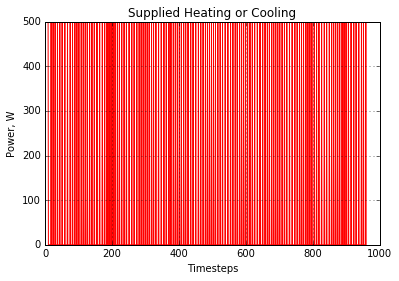

In [17]:
plt.plot(q_reqd,'r')
plt.xlabel('Timesteps')
plt.ylabel('Power, W')
plt.title('Supplied Heating or Cooling')
plt.grid()
plt.show()

Look at that! Typical. The room temperature slowly decays, the heater turns on full blast, heats up the room quickly and turns off. Then, the room temperature slowly decays. By changing the deadband temperature, we can reduce the cycling of the heater, but we may end up in larger temperature swings.

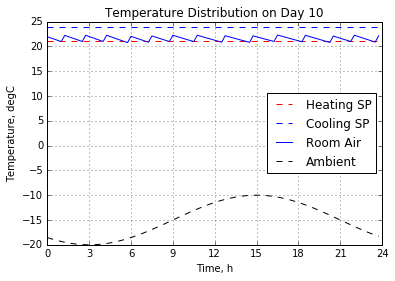

In [18]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.hold(True)
plotT = T[(days-1)*nt:(days)*nt:]
plt.plot(T_Setpoint_Heating,'r--')
plt.plot(T_Setpoint_Cooling,'b--')
plt.plot(np.dot(dt/3600.,range(0,nt)),plotT)
plotTK = TK[(days-1)*nt:(days)*nt:]
plt.plot(np.dot(dt/3600.,range(0,nt)),plotTK,'k--')
plt.xlim([0,24])
ax.set_xticks(np.arange(0,25,3))
plt.legend(['Heating SP','Cooling SP','Room Air','Ambient'],loc='best')
plt.xlabel('Time, h')
plt.ylabel('Temperature, degC')
plt.title('Temperature Distribution on Day %s' %(days))
plt.grid()
plt.show()

------------
## Run Simulation, Setpoints with  Night Time Setback, Ramped Change, Proportional Controls
In this section, we will be looking at proportional controls using night time setback. In offices and some residential buildings, when there are no occupants, the interior temperature is allowed to swing in a wider range. However, when occupants are expected to come back, the allowed range is narrowed.

In this example, the occupied range will be 21 to 24°C whereas the unoccupied range will be 17 to 28°C.

Try modifying the *ramp_dur* variable and see how it affects the peak heating or cooling demand. You may also need to shorten the simulation timestep to something more representative of the time it takes to actuate the heating or cooling systems.

In [19]:
q_reqd = np.zeros((nt*days, 1)) # heating/cooling supplied to air node
capacity = 1000.                # W, heating / cooling maximum capacity
Kp = capacity/0.5

# Temperature setpoint, using linear ramps
# Heating
T_SP = np.zeros((nt,1))         # degC; Interior temperature setpoint per timestep Heating
T_SP_day = 21.                  # daytime setpoint to maintain
T_SP_dT = 4.                    # setback amount
setback_beg = 18.               # setback beginning time (occupancy departure)
setback_end = 6.                # setback end time (occupancy arrival)
ramp_dur = 2.                   # hours, ramp duration; "0" equals to a step change
for t in range(0,nt):
    time = t*dt/3600.
    if (setback_beg <= time and time < (setback_beg+ramp_dur)):             # begin setback
        T_SP[t] = T_SP_day - (time-setback_beg)*T_SP_dT/ramp_dur
    elif ((setback_beg+ramp_dur) <= time or time < (setback_end-ramp_dur)): # night time
        T_SP[t] = T_SP_day - T_SP_dT
    elif ((setback_end-ramp_dur) <= time and time < setback_end):           # revert setback
        T_SP[t] = T_SP_day - (setback_end-time)*T_SP_dT/ramp_dur
    else:                                                                   # day time
        T_SP[t] = T_SP_day
        
# Cooling
T_SP_Cool = np.zeros((nt,1))    # degC; Interior temperature setpoint per timestep Cooling
T_SP_day_Cool = 24.
T_SP_dT_Cool = -4.             # -ve value increases temperature
setback_beg_Cool = 18.
setback_end_Cool = 6.
ramp_dur_Cool = 2.             # hours, ramp duration; "0" equals to a step change
for t in range(0,nt):
    time = t*dt/3600.
    if (setback_beg_Cool <= time and time < (setback_beg_Cool+ramp_dur_Cool)):                  # begin setback
        T_SP_Cool[t] = T_SP_day_Cool - (time-setback_beg_Cool)*T_SP_dT_Cool/ramp_dur_Cool
    elif ((setback_beg_Cool+ramp_dur_Cool) <= time or time < (setback_end_Cool-ramp_dur_Cool)): # night time
        T_SP_Cool[t] = T_SP_day_Cool - T_SP_dT_Cool
    elif ((setback_end_Cool-ramp_dur_Cool) <= time and time < setback_end_Cool):                # revert setback
        T_SP_Cool[t] = T_SP_day_Cool - (setback_end_Cool-time)*T_SP_dT_Cool/ramp_dur_Cool
    else:                                                                                       # day time
        T_SP_Cool[t] = T_SP_day_Cool

# Tile setpoints for every day        
T_Setpoint_Heating = np.tile(T_SP,(days,1))
T_Setpoint_Cooling = np.tile(T_SP_Cool,(days,1))

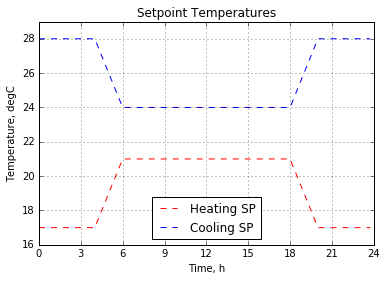

In [20]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.hold(True)
plotT_SP_Heating = T_Setpoint_Heating[(days-1)*nt:(days)*nt:]
plotT_SP_Cooling = T_Setpoint_Cooling[(days-1)*nt:(days)*nt:]
plt.plot(np.dot(dt/3600.,range(0,nt)),plotT_SP_Heating,'r--')
plt.plot(np.dot(dt/3600.,range(0,nt)),plotT_SP_Cooling,'b--')
plt.xlim([0,24])
plt.ylim([16,29])
ax.set_xticks(np.arange(0,25,3))
plt.legend(['Heating SP','Cooling SP'],loc='lower center')
plt.xlabel('Time, h')
plt.ylabel('Temperature, degC')
plt.title('Setpoint Temperatures')
plt.grid()
plt.show()

In [21]:
# Loop for number of days, and for all timesteps in a day
for d in range(0,days):
    for t in range(0,nt):
        
        # Heat flow into the node, external sources
        Qin = np.zeros((nN,1))
        # Determine if room temperature is below heating setpoint or above cooling setpoint
        # Auxiliary heating or cooling, P-control
        errHeatSP = T_Setpoint_Heating[d*nt+t] - T[d*nt+t,0] # heating SP error, +ve if violated
        errCoolSP = T[d*nt+t,0] - T_Setpoint_Cooling[d*nt+t] # cooling SP error, +ve if violated
        err = 0.5*(abs(errHeatSP)+errHeatSP) - 0.5*(abs(errCoolSP)+errCoolSP)
        # iTerm += Ki*SP_Err[d*nt+t]     # integral term, optional, you'll need to define "Ki"
        output = Kp*err # + iTerm
        if (output >  capacity): output =  capacity
        if (output < -capacity): output = -capacity
            # iTerm -= output - max_Cap
            # output = max_Cap
        # if output < min_Cap:  # use this if there is a minimial capacity that always needs to run
            # iTerm += min_Cap - output
            # output = min_Cap
        q_reqd[d*nt+t] = output
        Qin[0] = q_reqd[d*nt+t]
            
        # Q-vector: Q = Qin + F*TM(t) + C/dt*T(t)
        Q = Qin + np.reshape(np.dot(F, TK[d*nt+t,]),(nN,1)) + \
        np.multiply(C/dt, np.reshape(T[d*nt+t,:],(nN,1)))

        # Compute temperature
        # This is where the magic happens. For a system where nothing changes 
        # (no controls, no moveable blinds, no PCM; we need only define the 
        # U-matrix once (done above) and use it here)
        if (days*nt) > (d*nt+t+1):
            T[d*nt+t+1,] = np.linalg.solve(U,Q).T

### Plotting

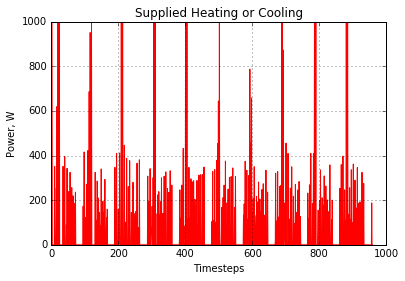

Peak power in heating: 1000 W, in cooling: 0 W


In [22]:
plt.plot(q_reqd,'r')
plt.xlabel('Timesteps')
plt.ylabel('Power, W')
plt.title('Supplied Heating or Cooling')
plt.grid()
plt.show()
print "Peak power in heating: %.0f W, in cooling: %.0f W" % \
        (max(q_reqd[(days-1)*nt:(days)*nt:]), min(q_reqd[(days-1)*nt:(days)*nt:]))

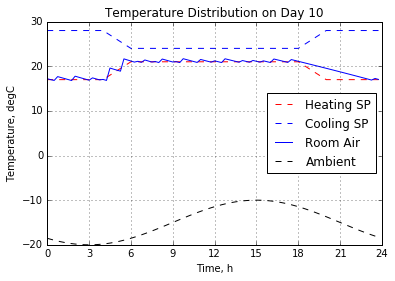

In [23]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.hold(True)
plotT = T[(days-1)*nt:(days)*nt:]
plotTSPHeat = T_Setpoint_Heating[(days-1)*nt:(days)*nt:]
plotTSPCool = T_Setpoint_Cooling[(days-1)*nt:(days)*nt:]
plt.plot(np.dot(dt/3600.,range(0,nt)),plotTSPHeat, 'r--')
plt.plot(np.dot(dt/3600.,range(0,nt)),plotTSPCool, 'b--')
plt.plot(np.dot(dt/3600.,range(0,nt)),plotT)
plotTK = TK[(days-1)*nt:(days)*nt:]
plt.plot(np.dot(dt/3600.,range(0,nt)),plotTK,'k--')
plt.xlim([0,24])
ax.set_xticks(np.arange(0,25,3))
plt.legend(['Heating SP','Cooling SP','Room Air','Ambient'],loc='best')
plt.xlabel('Time, h')
plt.ylabel('Temperature, degC')
plt.title('Temperature Distribution on Day %s' %(days))
plt.grid()
plt.show()